<a href="https://colab.research.google.com/github/sandroormeno/Machine-learning-with-3d-objects/blob/master/Tutorial_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
%cd '/content/drive/My Drive/Colab Notebooks/Tutorial 3D Scatter Plots in Python'

/content/drive/My Drive/Colab Notebooks/Tutorial 3D Scatter Plots in Python


In [2]:
ls

 3D_shape_inpainting/  'Tutorial 02.ipynb'  'Tutorial 06.ipynb'
 modelnet10.npz        'Tutorial 03.ipynb'  'Tutorial 07.ipynb'
 sphere.binvox         'Tutorial 04.ipynb'   Tutorial_08.ipynb
'Tutorial 01.ipynb'    'Tutorial 05.ipynb'


In [4]:
!git clone https://github.com/Fdevmsy/3D_shape_inpainting.git

fatal: destination path '3D_shape_inpainting' already exists and is not an empty directory.


In [3]:
%cd "/content/drive/My Drive/Colab Notebooks/Tutorial 3D Scatter Plots in Python/3D_shape_inpainting"

/content/drive/My Drive/Colab Notebooks/Tutorial 3D Scatter Plots in Python/3D_shape_inpainting


In [4]:
ls

32_cube/                images_64cube/    README.md  voxelFormat.pdf
EncoderDecoderGAN3D.py  images_64x32x32/  san/
images__32cube/         __pycache__/      utils.py


In [0]:
%tensorflow_version 1.x

In [6]:
import tensorflow
print(tensorflow.__version__)

1.15.0


In [7]:
from __future__ import print_function, division

import os
from mpl_toolkits.mplot3d import Axes3D  # you should keep the import
import matplotlib.pyplot as plt

import numpy as np
from keras.layers import BatchNormalization, Activation
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling3D, Conv3D, Deconv3D
from keras.models import Sequential, Model
from keras.models import load_model
from keras.optimizers import Adam
from keras import backend as K 
from sklearn.metrics import hamming_loss
from utils import mkdirs
from san import binvox_rw
from IPython.display import clear_output

Using TensorFlow backend.


In [0]:
IMAGE_DIR = './32_cube/images'
MODEL_DIR = './32_cube/saved_model'


In [0]:
mkdirs(IMAGE_DIR)
mkdirs(MODEL_DIR)

In [0]:
K.clear_session()

class EncoderDecoderGAN():
    def __init__(self):
        self.vol_rows = 32
        self.vol_cols = 32
        self.vol_height = 32
        self.mask_height = 16
        self.mask_width = 16
        self.mask_length = 16
        self.channels = 1
        self.num_classes = 2
        self.vol_shape = (self.vol_rows, self.vol_cols, self.vol_height, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.mask_length, self.channels)

        optimizer = Adam(0.0002, 0.5)

        try:
            self.discriminator = load_model(os.path.join(MODEL_DIR, 'discriminator.h5'))
            self.generator = load_model(os.path.join(MODEL_DIR, 'generator.h5'))

            print("Loaded checkpoints")
        except:
            self.generator = self.build_generator()
            self.discriminator = self.build_discriminator()
            print("No checkpoints found")

            # discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        # generator
        # The generator takes noise as input and generates the missing part
        masked_vol = Input(shape=self.vol_shape)
        gen_missing = self.generator(masked_vol)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated voxels as input and determines
        # if it is generated or if it is a real voxels
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_vol, [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
                              loss_weights=[0.999, 0.001],
                              optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv3D(32, kernel_size=5, strides=2, input_shape=self.vol_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv3D(64, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv3D(128, kernel_size=5, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv3D(512, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling3D())
        model.add(Deconv3D(256, kernel_size=5, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Deconv3D(128, kernel_size=5, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling3D())
        model.add(Deconv3D(64, kernel_size=5, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling3D())
        model.add(Deconv3D(self.channels, kernel_size=5, padding="same"))
        model.add(Activation('tanh'))
        model.summary()

        masked_vol = Input(shape=self.vol_shape)
        gen_missing = model(masked_vol)

        return Model(masked_vol, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv3D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv3D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv3D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        vol = Input(shape=self.missing_shape)
        validity = model(vol)

        return Model(vol, validity)

    def generateWall(self):
        x, y, z = np.indices((32, 32, 32))
        voxel = (x < 28) & (x > 5) & (y > 5) & (y < 28) & (z > 10) & (z < 25)
        # add channel
        voxel = voxel[..., np.newaxis].astype(np.float)
        # repeat 1000 times
        voxels = list()
        for i in range(1000):
            voxels.append(voxel)
        voxels = np.asarray(voxels)
        return voxels
    def generateSphere(self):
        file = '/content/drive/My Drive/Colab Notebooks/Tutorial 3D Scatter Plots in Python/sphere.binvox'
        with open(file, 'rb') as f:
          tem = binvox_rw.read_as_3d_array(f).data
        d = np.pad(tem, 2, 'constant')
        voxel = d[..., np.newaxis].astype(np.float)
        voxels = list()
        for i in range(1000):
            voxels.append(voxel)
        voxels = np.asarray(voxels)   
        return voxels


    def mask_randomly(self, vols):
        y1 = np.random.randint(0, self.vol_rows - self.mask_height, vols.shape[0])
        y2 = y1 + self.mask_height
        x1 = np.random.randint(0, self.vol_cols - self.mask_width, vols.shape[0])
        x2 = x1 + self.mask_width
        z1 = np.random.randint(0, self.vol_height - self.mask_length, vols.shape[0])
        z2 = z1 + self.mask_length

        masked_vols = np.empty_like(vols)
        missing_parts = np.empty((vols.shape[0], self.mask_height, self.mask_width, self.mask_length, self.channels))
        for i, vol in enumerate(vols):
            masked_vol = vol.copy()
            _y1, _y2, _x1, _x2, _z1, _z2 = y1[i], y2[i], x1[i], x2[i], z1[i], z2[i]
            missing_parts[i] = masked_vol[_y1:_y2, _x1:_x2, _z1:_z2, :].copy()
            masked_vol[_y1:_y2, _x1:_x2, _z1:_z2, :] = 0
            masked_vols[i] = masked_vol

        return masked_vols, missing_parts, (y1, y2, x1, x2, z1, z2)

    def train(self, epochs, batch_size=16, sample_interval=50):

        #X_train = self.generateWall()
        X_train = self.generateSphere()
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # Train Discriminator
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            vols = X_train[idx]
            masked_vols, missing_parts, _ = self.mask_randomly(vols)
            # Generate a batch
            gen_missing = self.generator.predict(masked_vols)
            # print(gen_missing.shape)

            d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            g_loss = self.combined.train_on_batch(masked_vols, [missing_parts, valid])
            print("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (
                epoch, d_loss[0], 100 * d_loss[1], g_loss[0], g_loss[1]))
            
            clear_output(wait=True)

            # save generated samples
            if epoch % sample_interval == 0:
                idx = np.random.randint(0, X_train.shape[0], 2)
                vols = X_train[idx]
                self.sample_images(epoch, vols)
                self.save_model()
                

    def sample_images(self, epoch, vols):
        r, c = 2, 2

        masked_vols, missing_parts, (y1, y2, x1, x2, z1, z2) = self.mask_randomly(vols)
        gen_missing = self.generator.predict(masked_vols)
        gen_missing = np.where(gen_missing > 0.5, 1, 0)
        fig = plt.figure(figsize=plt.figaspect(0.5), dpi=75)

        vols = 0.5 * vols + 0.5

        for i in range(2):
            masked_vol = masked_vols[i]
            masked_vol = masked_vol[:, :, :, 0].astype(np.bool)
            colors1 = np.empty(masked_vol.shape, dtype=object)
            colors1[masked_vol] = 'teal'
            ax = fig.add_subplot(1, 2, 1, projection='3d')
            ax.voxels(masked_vol, facecolors=colors1, edgecolor='black', linewidth=0.2)
            ax.set_title("Sphere damaged")
            plt.grid(False)
            plt.axis('off')

            filled_in = np.zeros_like(masked_vol)
            # filled_in = vols[i].copy()
            one_gen_missing = gen_missing[i]
            one_gen_missing = one_gen_missing[:, :, :, 0].astype(np.bool)

            # Compute hamming loss
            true_missing_part = missing_parts[i]
            true_missing_part = true_missing_part[:, :, :, 0].astype(np.bool)
            ham_loss = hamming_loss(true_missing_part.ravel(), one_gen_missing.ravel())

            filled_in[y1[i]:y2[i], x1[i]:x2[i], z1[i]:z2[i]] = one_gen_missing
            fill = filled_in
            combine_voxels = masked_vol | fill

            # https://matplotlib.org/3.1.1/gallery/color/named_colors.html#sphx-glr-gallery-color-named-colors-py

            colors2 = np.empty(combine_voxels.shape, dtype=object)
            colors2[masked_vol] = 'teal'
            colors2[fill] = 'olive'

            ax = fig.add_subplot(1, 2, 2, projection='3d')
            ax.voxels(combine_voxels, facecolors=colors2, edgecolor='black', linewidth=0.2)
            # ax.voxels(masked_vol, facecolors=colors1, edgecolor='k')
            # ax.set_title("Hamming Loss: %f" % ham_loss)
            ax.set_title("Sphere repaired")
            plt.grid(False)
            plt.axis('off')
            fig.savefig(os.path.join(IMAGE_DIR, "%d_%d.png" % (epoch, i)))
            #print("saved sample images")
            #plt.close()
            #plt.axis('off')
            
        plt.show()

    def save_model(self):
        def save(model, model_name):
            model_path = os.path.join(MODEL_DIR, "%s.h5" % model_name)
            model.save(model_path)

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

In [0]:
context_encoder = EncoderDecoderGAN()

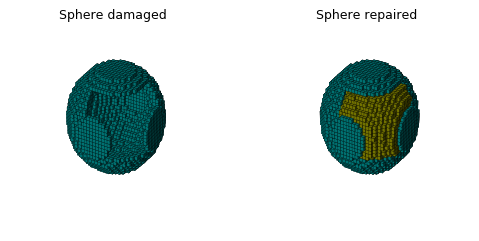

In [36]:
context_encoder.train(epochs=3001, batch_size=5, sample_interval=200)

In [0]:
X = context_encoder.generateSphere()

In [38]:
X.shape

(1000, 32, 32, 32, 1)

In [0]:
#context_encoder.sample_images(12,X[32])
i = np.random.randint(0, X.shape[0], 5)
vol = X[i]

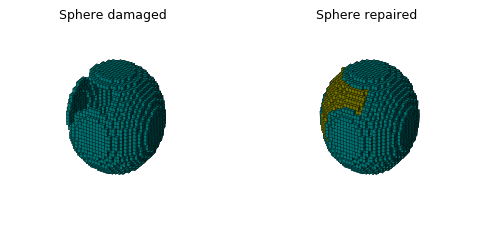

In [53]:
context_encoder.sample_images(5,vol)

In [51]:
context_encoder.build_generator()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 16, 16, 16, 32)    4032      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 16, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 16, 32)    128       
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 8, 8, 8, 64)       256064    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 8, 64)       0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 8, 64)       256       
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 4, 4, 4, 128)     

In [52]:
context_encoder.build_discriminator()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_19 (Conv3D)           (None, 8, 8, 8, 64)       1792      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 8, 64)       0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 8, 8, 8, 64)       256       
_________________________________________________________________
conv3d_20 (Conv3D)           (None, 4, 4, 4, 128)      221312    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 4, 4, 4, 128)      0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 4, 4, 4, 128)      512       
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 4, 4, 4, 256)     